# Creating a striplog from an image

In this recipe we will show how to create a `striplog` from one Peter Giles' images.

First, import modules we might need

In [1]:
import matplotlib.pyplot as plt
% matplotlib inline

import numpy as np

import striplog
striplog.__version__

'0.7.0'

## Making a striplog

In [2]:
from striplog import Striplog, Legend
imgfile = "data/images/P-140_Giles_15_1527.png"

Let's take a look at the <b>image</b>. This is not yet a striplog. Use `imread` to create a numpy array, `im`, from the image.


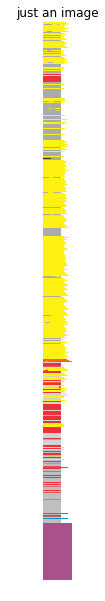

In [3]:
from pylab import imread
im = imread(imgfile)
plt.figure(figsize=(2,10))
plt.imshow(im, aspect=0.5)
plt.axis('off')
plt.title("just an image")
plt.show()

# Make a legend

In [4]:
# Peter Giles Legend

LEGEND_GILES = """colour, width, component lithology, component colour
#FFF057, 6, Sandstone, Grey,
#A9ABAE, 4, Siltstone, Grey,
#EF303D, 4, Siltstone, Red,
#FF642A, 4, Conglomerate, ,
#373435, 2, Coal, ,
#009AD4, 4, Dolomite, ,
#A95286, 7, Rhyolite, ,
"""

In [5]:
type(LEGEND_GILES)

str

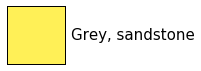

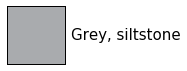

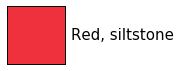

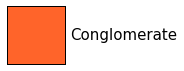

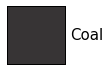

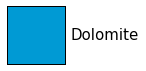

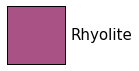

In [6]:
PeterLegend = Legend.from_csv(LEGEND_GILES)
PeterLegend.plot()

In the file name we have indicated the top (25 m) and bottom (2618 m) extents of the image. 

In [7]:
top, base = 15.0, 1527.0
tolerance = 100  # increase this number to allow for more tolerance to colour match with legend
strip = Striplog.from_image(imgfile, top, base, tolerance = 100, legend=PeterLegend)
strip

/Users/Evan/anaconda/envs/welly/lib/python3.5/site-packages/striplog/legend.py:754: UserWarning: No match found for #ffffff with tolerance of 100. Best match is Grey, siltstone, #a9abae, d=144.9586147836685
  warnings.warn(w)


Striplog(476 Intervals, start=15.0, stop=1527.0)

In [8]:
strip[-5]

Interval({'components': [Component({'lithology': 'rhyolite', 'colour': ''})], 'data': {}, 'base': Position({'units': 'm', 'middle': 1473.6223194748359}), 'description': '', 'top': Position({'units': 'm', 'middle': 1460.5536105032822})})

In [9]:
strip.thinnest()

Interval({'components': [Component({'lithology': 'siltstone', 'colour': 'grey'})], 'data': {}, 'base': Position({'units': 'm', 'middle': 574.4179431072209}), 'description': '', 'top': Position({'units': 'm', 'middle': 574.2525164113786})})

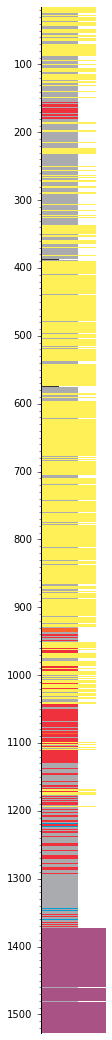

In [12]:
%matplotlib inline
strip.plot(PeterLegend, ladder=True)

Do we need to deal with gaps or overlaps?

In [13]:
# let's see if there are any
print(strip.find_gaps())

None
